# Homework set 3

Please **submit this Jupyter notebook through Canvas** no later than **Monday December 2**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. On canvas there are hints about creating a nice pdf version.**

Before you hand in, please make sure the notebook runs, by running "Restart kernel and run all cells..." from the Kernel menu.

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

$$
\newcommand{\bfA}{\boldsymbol{A}}
\newcommand{\bfB}{\boldsymbol{B}}
\newcommand{\bfJ}{\boldsymbol{J}}
\newcommand{\bfr}{\boldsymbol{r}}
\newcommand{\bfs}{\boldsymbol{s}}
\newcommand{\bfx}{\boldsymbol{x}}
\newcommand{\for}{\text{\bf for }}
\renewcommand{\end}{\text{\bf end }}
$$

# Exercise 0
Write down the names + student ID of the people in your group.

Run the following cell to import NumPy, Matplotlib. If anything else is needed you can import this yourself.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Exercise 1: Nonlinear least squares

This exercise is about the Gauss-Newton method, and the Levenberg-Marquardt method, which are discussed in section 6.6 of Heath. Please read this section before making this homework set. **In this exercise set the Levenberg-Marquardt method is a little different from the one in Heath. The first equation in subsection 6.6.2 is replaced by**
$$
\renewcommand{\bfA}{\boldsymbol{A}}
\renewcommand{\bfB}{\boldsymbol{B}}
\renewcommand{\bfJ}{\boldsymbol{J}}
\renewcommand{\bfr}{\boldsymbol{r}}
\renewcommand{\bfs}{\boldsymbol{s}}
\renewcommand{\bfx}{\boldsymbol{x}}
\renewcommand{\for}{\text{\bf for }}
\renewcommand{\end}{\text{\bf end }}
\bigg(\bfJ^T(\bfx_k) \bfJ(\bfx_k) 
+ \mu_k \operatorname{Diagonal}\big( \bfJ^T(\bfx_k) \bfJ(\bfx_k) \big) \bigg) \bfs_k
= - \bfJ^T(\bfx_k) \, \bfr(\bfx_k)
$$
Here $\operatorname{Diagonal}(\bfB)$ denotes the diagonal part of $\bfB$. So $\operatorname{Diagonal}(\bfB)$ has the same shape as $\bfB$ and identical entries on the diagonal and it has zero off-diagonal entries.

The algorithm for Levenberg-Marquardt, with $\mu_k$ constant (denoted $\mu$ here), is then</br>
$\qquad \bfx_0 = \text{initial guess}$</br>
$\qquad \mu = \text{constant}$</br>
$\qquad \for k = 0,1,2, \ldots$</br>
$\qquad \qquad \bfA = \bfJ_f(\bfx_k)$</br>
$\qquad \qquad \text{solve } \bfs_k \text{ from } 
(\bfA^T \bfA + \mu \operatorname{Diagonal}(\bfA^T \bfA)) \bfs_k = - \bfA^T \bfr(\bfx_k)$</br>
$\qquad \qquad \bfx_{k+1} = \bfx_k + \bfs_k$</br>
$\qquad \end$</br>

This reduces to the Gauss-Newton method if $\mu = 0$. 

## (a)
Implement the Levenberg-Marquardt method with constant $\mu$ using a suitable stopping criterion. 
Make it such that the user can specify the value of the tolerance in the stopping criterion via a parameter `tol` and the maximum number of iterations via a
parameter `maxIter`. In the implementation you can use library functions for linear algebra operations. 

In [22]:
# Q1: implement L-M
def residual(c1, c2, t_array, y_array, function):
    return y_array - function(t_array, c1, c2)

# Q2: must implement `tol` and `maxIter`
def levenberg_marquardt(c0, mu, function, jacobian, t_array, y_array, tol=1e-5, maxIter=100): 
    c = np.copy(c0)
    for i in range(maxIter):
    
        J_x = jacobian(t_array, c[0], c[1])
        r_x = residual(c[0], c[1], t_array, y_array, function)

        JTJ = J_x.T @ J_x
        damped_JTJ = JTJ + mu * np.diag(np.diag(JTJ))
        JTR = J_x.T @ r_x

        s_k = np.linalg.solve(damped_JTJ, -JTR)
        c -= s_k
        if np.linalg.norm(r_x) < tol or np.linalg.norm(s_k) < tol:
            return c, i + 1
    return c, maxIter

## (b) 

The time course of drug concentration $y$ in the bloodstream is well described by
$$ \tag{1}
  y = c_1 t e^{c_2 t} ,
$$
where $t$ denotes time after the drug was administered. The characteristics of the model
are a quick rise as the drug enters the bloodstream, followed by slow exponential decay.
The half-life of the drug is the time from the peak concentration to the time it drops to
half that level. The measured level of the drug norfluoxetine in a patient's bloodstream at whole hours after it was administered is given in the following data:

In [23]:
# time in hours
hour = np.array( [ 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0 ] )
# concentration in ng/ml
concentration = np.array( [ 8.0, 12.3, 15.5, 16.8, 17.1, 15.8, 15.2, 14.0 ] )


Use the Gauss-Newton method to fit this data to the blood concentration model (1).

Also use the Levenberg-Marquardt method with $\mu =0.1$ to address the same problem.

Which method produces the least number of iterations? N.B. clearly state the starting point. 

You are asked to use your own version of Gauss-Newton and Levenberg-Marquardt.

Gauss-Newton computed the values:        [ 9.79692816 -0.21508717] in 12 iterations.
Levenberg-Marquardt computed the values: [ 9.79691555 -0.21508692] in 25 iterations.

When starting with the initial guess of [c1, c2] = [-1.  -0.1],
Gauss-Newton needed the least iterations: 12,
whereas Levenberg-Marquardt completed in 25 iterations.


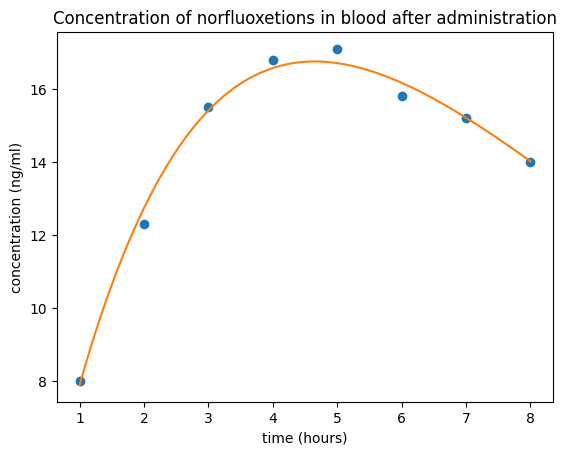

In [35]:
def drug_time_f(t, c1, c2):
    return c1 * t * np.exp( c2 * t )

# F = x1*t*np.exp(x2*t)
def jacobian_func(times, c1, c2):
    J = np.zeros((8, 2))  
    
    for i, t in enumerate(times):
        J[i, 0] = t * np.exp(c2 * t)             
        J[i, 1] = c1 * t**2 * np.exp(c2 * t)
    
    return J


# Q1: use G-N on data
c_start = np.array([-1, -0.1])
mu = 0.0
root_gn, iter_count_gn = levenberg_marquardt(c_start, mu, drug_time_f, jacobian_func, hour, concentration)
print(f"Gauss-Newton computed the values:        {root_gn} in {iter_count_gn} iterations.")

# Q2: also use L-M with mu=0.1
mu = 0.1
root_lm, iter_count_lm = levenberg_marquardt(c_start, mu, drug_time_f, jacobian_func, hour, concentration)
print(f"Levenberg-Marquardt computed the values: {root_lm} in {iter_count_lm} iterations.")

print()
# Q4: clearly state starting point
print(f"When starting with the initial guess of [c1, c2] = {c_start},")
# Q3: which methods had least iterations? 
print(f"Gauss-Newton needed the least iterations: {iter_count_gn},")
print(f"whereas Levenberg-Marquardt completed in {iter_count_lm} iterations.")

x_range = np.linspace(hour[0], hour[-1], 1000)
plt.plot(hour, concentration, "o")
plt.plot(x_range, drug_time_f(x_range, root_lm[0], root_lm[1]))
plt.xlabel("time (hours)")
plt.ylabel("concentration (ng/ml)")
plt.title("Concentration of norfluoxetions in blood after administration")
plt.show()

# (c)
Try to find a starting point such that Gauss-Newton does not converge, while Levenberg-Marquardt does.



In [25]:
# YOUR CODE HERE

# (d) 
So far for simplicity, we considered constant $\mu$. However
Levenberg-Marquardt is often applied adaptively with a varying $\mu$. 
A common strategy is to continue to decrease $\mu$ by a factor of 10 on each iteration step as long as the residual sum of squared errors is decreased by the step, and if the sum increases, to reject the step and increase $\mu$ by a factor of 10.

Implement an adaptive variant of Levenberg-Marquardt using such a strategy for choosing $\mu$. 

Compare the performance (iteration number) of the adaptive variant with Gauss-Newton and the previous, non-adaptive variant of Levenberg-Marquardt. Consider a starting point for which Gauss-Newton converged rapidly and a starting point for which Gauss-Newton did not converge, but non-adaptive Levenberg-Marquardt did. Give your answer in a table for clarity, also indicating the starting point and if relevant other parameters.

In [ ]:
# Q1: implement L-M
def residual(c1, c2, t_array, y_array, function):
    return y_array - function(t_array, c1, c2)

# Q2: must implement `tol` and `maxIter`
def levenberg_marquardt(c0, mu, function, jacobian, t_array, y_array, tol=1e-5, maxIter=100): 
    c = np.copy(c0)
    for i in range(maxIter):
    
        J_x = jacobian(t_array, c[0], c[1])
        r_x = residual(c[0], c[1], t_array, y_array, function)
        old_residual_norm = np.linalg.solve(r_x)

        JTJ = J_x.T @ J_x
        damped_JTJ = JTJ + mu * np.diag(np.diag(JTJ))
        JTR = J_x.T @ r_x

        s_k = np.linalg.solve(damped_JTJ, -JTR)
        c_new= c- s_k

        r_x_new = residual(c_new[0], c_new[1], t_array, y_array, function)
        new_residual_norm = np.linalg.norm(r_x_new)

        if new_residual_norm < old_residual_norm:
            mu *= 0.1
            c = c_new
        else:
            mu *= 10

        if np.linalg.norm(r_x) < tol or np.linalg.norm(s_k) < tol:
            return c, i + 1, mu
    return c, maxIter